In [1]:
import tensorflow as tf
import os
import numpy as np
import pickle
import random
import scipy.misc as smp

In [2]:
RANDOM_VEC_SIZE = 512

SIZE = 96
CLASSES = 10
CHANNELS = 3

RUN_NAME = random.randint(0, 10000)
print("Current Run: " + str(RUN_NAME))

Current Run: 6127


In [3]:
from PIL import Image

data_path = "data/danbooru/faces/anime-faces/"

def read_file(file_path):
    return Image.open(file_path)

def load_data():
    images = []
    labels = []
    for path in os.listdir(data_path):
        print("Loading " + path, end="\r")
        curr_path = data_path + path
        
        if os.path.isfile(curr_path):
            continue
            
        for file in os.listdir(curr_path):
            file_path = curr_path + "/" + file
            
            try:
                img = Image.open(file_path)

                images.append(np.array(img).reshape((SIZE**2 * CHANNELS)))
                labels.append(0)
            except:
                print(file_path)
    
    return images, labels, None

In [4]:
train_images, train_labels, test_data = load_data()

#test_images = test_data[b'data']
#test_labels = test_data[b'labels']

data/danbooru/faces/anime-faces/aqua_eyes/._danbooru_2560862_796530ab01cc7bfd8a03c8d05cc6953b.png
data/danbooru/faces/anime-faces/aqua_eyes/._danbooru_2559693_dc628b766d7142f2d2d9c75559e36eb5.jpg
data/danbooru/faces/anime-faces/apron/danbooru_2580459_260d16d018b7d945b64cc601d4adc153.jpg


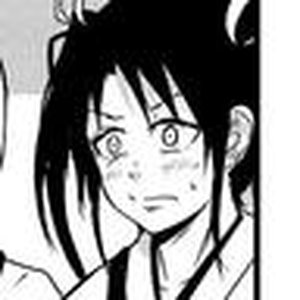

In [5]:
from PIL import Image 

def display_img(data):
    img = np.reshape(data, (SIZE,SIZE,CHANNELS))
    return Image.fromarray(img.astype("uint8")).resize((300,300), Image.ANTIALIAS)

display_img(train_images[0])

In [6]:
sess = tf.InteractiveSession()

In [7]:
def generator(z, is_train=True, out_channel_dim=3):
    alpha = 0.2
    fc_size = 512
    
    def deconv(net, printVal=True):
        side_len = net.shape[3] // 2
        
        deconv = tf.layers.conv2d_transpose(net, side_len, 5, 2, padding="SAME")
        batch_norm = tf.layers.batch_normalization(deconv, training=is_train)
        lrelu = tf.nn.leaky_relu(batch_norm, alpha)
        
        if printVal:
            print(str(lrelu.shape))
        
        return lrelu
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        print("GENERATOR")
        fc_1 = tf.layers.dense(z, fc_size * (SIZE//16)**2)
        fc_1 = tf.reshape(fc_1, [-1, SIZE//16, SIZE//16, fc_size])
        batch_norm_1 = tf.layers.batch_normalization(fc_1, training=is_train)
        net = tf.nn.leaky_relu(batch_norm_1, alpha)
        
        net = deconv(net)
        net = deconv(net)
        net = deconv(net)        
        
        logits = tf.layers.conv2d_transpose(net, out_channel_dim, 5, 2, padding="SAME")
        print("Final Shape: " + str(logits.shape))
        
        return tf.tanh(logits)

In [8]:
def discrim(images, reuse=False, is_train=True, num_channels=3):
    alpha = 0.2
    
    def conv(net, printVal=True):
        size = net.shape[3] * 2
        
        conv = tf.layers.conv2d(net, size, 5, 2, "SAME")
        batch_norm = tf.layers.batch_normalization(conv, training=is_train)
        lrelu = tf.nn.leaky_relu(batch_norm, alpha)
        
        print(lrelu.shape)
        return lrelu
    #I have no idea why the variable naming convention suddenly changed here
    with tf.variable_scope("discrim", reuse=reuse):
        print("DISCRIM")
        conv1 = tf.layers.conv2d(images, 64, 5, 2, "SAME")
        net = tf.nn.leaky_relu(conv1, alpha)
        
        net = conv(net)
        net = conv(net)
        net = conv(net)
        net = conv(net)
        
        size = net.shape[1] * net.shape[2] * net.shape[3]
        net = tf.reshape(net, [-1, size])
        
        logits = tf.layers.dense(net, 1)
        
        return logits, tf.sigmoid(logits)  
        

In [9]:
def model_loss(input_real, input_z, num_channels=3):
    label_smoothing = 0.9
    
    fake_out = generator(input_z)
    G_sample_image = tf.summary.image("Deep_GAN{}".format(RUN_NAME), fake_out)
    
    real_logits, real_probs = discrim(tf.reshape(input_real, [-1, SIZE, SIZE, num_channels]))
    fake_logits, fake_probs = discrim(fake_out, True)
    
    D_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=label_smoothing * tf.ones_like(real_logits)))
    D_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    D_accur = (tf.reduce_mean(tf.round(real_probs)) + tf.reduce_mean(tf.round(1 - fake_probs))) / 2
    
    D_loss = D_loss_real + D_loss_fake
    
    G_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=label_smoothing * tf.ones_like(fake_logits)))
    
    return D_loss, D_accur, G_loss

In [10]:
def opt(D_loss, G_loss, learning_rate, beta1, weight_decay=0.01):
    t_vars = tf.trainable_variables()
    
    D_loss += tf.add_n([tf.nn.l2_loss(var) for var in t_vars if var.name.startswith("discrim")]) * weight_decay
    d_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
        D_loss, var_list=[var for var in t_vars if var.name.startswith("discrim")])
    
    
    G_loss += tf.add_n([tf.nn.l2_loss(var) for var in t_vars if var.name.startswith("generator")]) * weight_decay
    g_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
        G_loss, var_list=[var for var in t_vars if var.name.startswith("generator")])
    
    return d_train, g_train

In [11]:
Z = tf.placeholder(tf.float32, [None, RANDOM_VEC_SIZE])
X = tf.placeholder(tf.float32, [None, SIZE**2 * CHANNELS])

X = X + tf.random_normal(shape=tf.shape(X), mean=0.0, stddev=0.1, dtype=tf.float32)


D_loss, D_accur, G_loss = model_loss(X, Z)

tf.summary.scalar("D_loss{}".format(RUN_NAME), D_loss)
tf.summary.scalar("G_loss{}".format(RUN_NAME), G_loss)

all_summaries = tf.summary.merge_all()
D_trainer, G_trainer = opt(D_loss, G_loss, 1e-4, 0.5)

GENERATOR
(?, 12, 12, 256)
(?, 24, 24, 128)
(?, 48, 48, 64)
Final Shape: (?, 96, 96, 3)
DISCRIM
(?, 24, 24, 128)
(?, 12, 12, 256)
(?, 6, 6, 512)
(?, 3, 3, 1024)
DISCRIM
(?, 24, 24, 128)
(?, 12, 12, 256)
(?, 6, 6, 512)
(?, 3, 3, 1024)


In [12]:
def sample_Z(batch_size):
    return np.random.uniform(-1, 1, [batch_size, RANDOM_VEC_SIZE])

np.random.seed(0xDEADBEEF)

In [13]:
tf.global_variables_initializer().run()

summary_writer = tf.summary.FileWriter("tmp/logs", sess.graph)

In [14]:
def generate_data(batch_size):
    indices = np.random.randint(0, len(train_images), [batch_size])
    return [np.divide(train_images[i].astype(np.float32), 256) for i in indices], [train_labels[i] for i in indices]

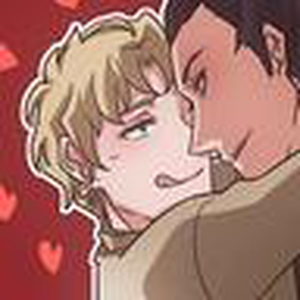

In [15]:
display_img(np.multiply(generate_data(1)[0][0], 256))

In [16]:
ITER = 0

In [ ]:
BATCH_SIZE = 128
FAKE_BATCH_SIZE = 128

DISCR_ITERS = 10
GEN_ITERS = 3

for TRAIN_ITER in range(1000000):
    
    for _ in range(DISCR_ITERS):
        batch, _ = generate_data(BATCH_SIZE)
        fake_batch = sample_Z(FAKE_BATCH_SIZE)
        D_trainer.run(feed_dict={Z: fake_batch, X: batch})
    for _ in range(GEN_ITERS):
        batch, _ = generate_data(BATCH_SIZE)
        fake_batch = sample_Z(FAKE_BATCH_SIZE)
        G_trainer.run(feed_dict={Z: fake_batch, X: batch})
    
    ITER += 1
    if TRAIN_ITER % 10 == 0:
        
        batch, _ = generate_data(BATCH_SIZE)
        fake_batch = sample_Z(FAKE_BATCH_SIZE)
        
        D_train_loss, G_train_loss, D_train_accur, summary = sess.run([D_loss, G_loss, D_accur, all_summaries], 
                                                                      feed_dict={Z: fake_batch, X: batch})

        print("Iter %05d: Losses: %.2f and %.2f | Accur: %.2f%%"%(ITER, D_train_loss, G_train_loss, 100 * D_train_accur))

        summary_writer.add_summary(summary, ITER)
        summary_writer.flush()

Iter 00001: Losses: 0.61 and 3.33 | Accur: 89.84%
Iter 00011: Losses: 3.94 and 0.39 | Accur: 50.00%
Iter 00021: Losses: 0.83 and 1.02 | Accur: 89.84%
Iter 00031: Losses: 0.92 and 0.85 | Accur: 87.50%
Iter 00041: Losses: 0.48 and 2.11 | Accur: 100.00%
Iter 00051: Losses: 0.90 and 0.91 | Accur: 87.50%
Iter 00061: Losses: 0.59 and 1.49 | Accur: 100.00%
Iter 00071: Losses: 0.41 and 2.54 | Accur: 100.00%
Iter 00081: Losses: 1.03 and 0.75 | Accur: 76.17%
Iter 00091: Losses: 0.54 and 1.68 | Accur: 99.61%
Iter 00101: Losses: 0.71 and 1.17 | Accur: 97.66%
Iter 00111: Losses: 0.77 and 1.06 | Accur: 95.70%
Iter 00121: Losses: 0.58 and 1.53 | Accur: 100.00%
Iter 00131: Losses: 0.48 and 2.05 | Accur: 100.00%
Iter 00141: Losses: 0.54 and 1.76 | Accur: 99.61%
Iter 00151: Losses: 0.56 and 1.65 | Accur: 100.00%
Iter 00161: Losses: 0.55 and 1.64 | Accur: 100.00%
Iter 00171: Losses: 0.55 and 1.64 | Accur: 100.00%
Iter 00181: Losses: 0.48 and 2.08 | Accur: 99.61%
Iter 00191: Losses: 0.41 and 2.73 | Accur: